# Tracking Eigenvalues: The Shift-Invert Power Method

### 1. The Strategy
When studying how a Hamiltonian $H(\lambda)$ behaves as we vary a parameter $\lambda$, we don't need to re-diagonalize the whole matrix at every step. Instead, we use a **"tracking" strategy**:

* **The Anchor:** We start with a full diagonalization for an initial $\lambda_0$ to get our baseline energy $E(\lambda_0)$.
* **The Follow-up:** As we shift $\lambda$ slightly, we assume the new energy will be close to the previous one. We use the previous energy as a "guess" or "shift", denoted $\tilde{E}(\lambda)$.

---

### 2. Why Shift-Invert?
The goal is to force the Power Method to ignore the edges of the spectrum and focus exactly on the energy level we are tracking. We do this by applying the iteration to the inverse operator:

$$[H - \tilde{E}(\lambda)I]^{-1} |\psi_n\rangle = \eta |\psi_{n+1}\rangle$$

In this setup, the closer the actual energy $E$ is to our guess $\tilde{E}$, the more the term $1/(E - \tilde{E})$ blows up, making that specific state dominant. This allows the algorithm to converge very quickly to the state we are following.



---

### 3. Avoiding Matrix Inversion
In practice, explicitly calculating the inverse matrix $[H - \tilde{E}I]^{-1}$ is **extremely long and computationally expensive**, especially for large systems. 

To get around this, we treat each step as a linear system to solve:
$$(H - \tilde{E}I) |w\rangle = |\psi_n\rangle$$

We use the **MINRES** algorithm to find $|w\rangle$. It's a clever iterative solver that finds the solution without ever needing to actually invert the matrix, saving a massive amount of time and memory.

---

### 4. Getting the Results Back
Once the iteration settles, we have successfully "captured" the state. We can then easily recover the physical properties of the system:

* **The Eigenvector:** The converged $|\psi\rangle$ is the new state of your Hamiltonian.
* **The Eigenvalue:** We find the energy $E$ simply by calculating the **Rayleigh quotient**:

$$E = \frac{\langle\psi|H|\psi\rangle}{\langle\psi|\psi\rangle}$$

---

To implement it, we will use the following hamiltonian which is the transmon readout one : 
$$\hat{H} = \left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right] \otimes \mathbb{I} 
+ \mathbb{I} \otimes \left( \hbar\omega(\hat{a}^\dagger\hat{a}) + \frac{1}{2} \right)
- 4E_{coupling} \hat{n}_T \otimes \left(i n_{ZPF}(\hat{a}^\dagger - \hat{a}) \right)$$

In [445]:
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sp_linalg


### Shift invert implementation

In [446]:
# The function to do one calculation step


def shift_invert_step(H_op, E_guess, v_prev, tol=1e-8):
    n = H_op.shape[0]
    v_current = v_prev.astype(np.float64)
    E_current = E_guess

    for _ in range(10):

        def shifted_matvec(v):
            return (H_op @ v) - E_current * v

        H_shifted = sp_linalg.LinearOperator((n, n), matvec=shifted_matvec, dtype=np.float64)

        w, exit_code = sp_linalg.minres(H_shifted, v_current, x0=v_current, tol=tol)

        if np.linalg.norm(w) < 1e-14:
            return E_current, v_current

        v_new = w / np.linalg.norm(w)
        E_new = np.vdot(v_new, H_op @ v_new).real

        if np.abs(E_new - E_current) < tol:
            return E_new, v_new

        v_current = v_new
        E_current = E_new
    return E_current, v_current


In [447]:
# The function to determine the whole branch
# param_list is the list of the different values on which we want to plot our hamiltonian


def get_branch(H_func, E_0, v_0, param_list, tol=1e-8):
    n_steps = len(param_list)
    energies, vectors = np.zeros(n_steps, dtype=np.float64), []
    E_current, v_current = E_0, v_0

    energies[0] = E_current
    vectors.append(v_current.astype(np.float64))

    for i in range(1, n_steps):
        H_at_param = H_func(param_list[i])

        E_current, v_current = shift_invert_step(H_at_param, E_current, v_current, tol=tol)

        energies[i] = E_current
        vectors.append(v_current.astype(np.float64))

    energies.astype(np.float64)

    return energies, np.array(vectors)

In [448]:
# This function use the other one to give all the values. It started by computing exact diagonalisation and compute
# iteratively the different branches. n_branches gives the number of eigen_value to compute.


def get_values_shift_invert(H_func, n_branches, param_list, tol=1e-8):
    H_0 = H_func(param_list[0])

    E_initial, v_initial = sp_linalg.eigsh(H_0, k=n_branches, which="SA")
    v_initial = v_initial.astype(np.float64)

    all_energies = []
    all_vectors = []

    for i in range(n_branches):
        E0_i = E_initial[i]
        v0_i = v_initial[:, i]

        energies_i, vectors_i = get_branch(H_func, E0_i, v0_i, param_list, tol=tol)

        all_energies.append(energies_i)
        all_vectors.append(vectors_i)

    return np.array(all_energies), np.array(all_vectors)

### Classical Lanczos implementation

In [449]:
def get_values_Lanczos(H_func, n_branches, param_list, tol=1e-8):
    all_energies = []
    all_vectors = []

    for i in range(len(param_list)):
        H = H_func(param_list[i])

        energies_i, vectors_i = sp_linalg.eigsh(H, k=n_branches, which="SA")

        all_energies.append(energies_i)
        all_vectors.append(vectors_i)

    return np.array(all_energies).transpose(), np.array(all_vectors).transpose()

## Transmon readout application

To begin, we will define the tensorial product to accelerate the computation of $H |\psi \rangle$

## 

In [450]:
def apply_tensor_product(axes: int, H: sp.spmatrix, V: np.ndarray) -> np.ndarray:
    """
    Apply sparse matrix H to the specified axis of tensor V

    Args:
        axes: which axis to apply the operator to (0, 1, 2, or 3)
        H: sparse matrix operator
        V: multi-dimensional array

    Returns:
        Result of applying H to axis 'axes' of V

    The following implementation works 3-4 times faster on smaller matrices:
    - np.einsum("ij,jabc->iabc", H, V)
    - np.dot between N-D and M-D matrices
    - reshaping and applying matrix multiplication
    However, all of them are impossible to use with sparse matrices.
    For larger matrices the implementation below for sparse matrix is faster
    by 1-1.5 times compare to implementations above on dense matrices

    """
    selected_axes_len = V.shape[axes]
    V = np.swapaxes(V, axes, 0)
    shape = V.shape
    V = np.reshape(V, (selected_axes_len, -1))
    # Apply sparse matrix multiplication
    result = H @ V
    result = np.reshape(result, shape)
    return np.swapaxes(result, 0, axes)

## Reducing the hamiltonian related to the transmon

We are aiming to compute the coupled hamiltonian for the readout transmon for higher values of the readout cutoff. To do this, we will compute the Transmon eigenvectors alone, then inject them in the coupled hamiltonian.

We are starting from this hamiltonian : 
$$\hat{H} = \left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right] \otimes \mathbb{I} 
+ \mathbb{I} \otimes \left( \hbar\omega(\hat{a}^\dagger\hat{a}) + \frac{1}{2} \right)
- 4E_{coupling} \hat{n}_T \otimes \left(i n_{ZPF}(\hat{a}^\dagger - \hat{a}) \right)$$

Studying $\left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right]$ in the charge basis gives us the decomposition in the diagonale basis, $$\left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right] = \sum^{2*cutoff+1}_{i=0} \lambda_i |\psi_i \rangle \langle \psi_i| \quad \text{with} \quad |\lambda_i \rangle = \sum_{j=-cutoff}^{cutoff} c_{ij} | i \rangle$$

We will select the 4 lowest energies and extract a 4*4 matrix with them. Same for $\hat{n_t}$ that we will project on this 4 vector space.We will 

Then, we are able to build the whole operator which depends on the physical constants.

In [451]:
def reduce_transmon_operators(Op_charge_T, Op_tunnel_T, Op_n_T, EJ, EC_T, n_transmon_keep):
    """
    Construit l'Hamiltonien transmon dans la base de charge complète,
    diagonalise pour trouver les n_transmon_keep premiers états,
    et projette H et n_T dans ce sous-espace.
    """

    H_T_full = 4.0 * EC_T * Op_charge_T - 0.5 * EJ * Op_tunnel_T

    evals, evecs = sp_linalg.eigsh(H_T_full, k=n_transmon_keep, which="SA")

    sort_indices = np.argsort(evals)
    evals = evals[sort_indices]
    evecs = evecs[:, sort_indices]

    H_T_reduced = sp.diags(evals, format="csr")

    n_T_projected = evecs.conj().T @ (Op_n_T @ evecs)

    n_T_reduced = sp.csr_matrix(n_T_projected)

    return H_T_reduced, n_T_reduced

We use this function to build only one time the big matrixes that cost a lot in memory

In [452]:
def build_naked_operators(n_cut=31, osc_cut=10):

    dim_T = 2 * n_cut + 1
    
    n_values = np.arange(-n_cut, n_cut + 1)
    Op_charge_T = sp.diags(n_values**2, format='csr') # Juste n^2
    
    Op_n_T = sp.diags(n_values, format='csr')

    ones = np.ones(dim_T - 1)
    Op_tunnel_T = sp.diags([ones, ones], offsets=[-1, 1], format='csr')

    dim_R = osc_cut
    sqrt_vals = np.sqrt(np.arange(1, osc_cut))
    a = sp.diags(sqrt_vals, offsets=1, format='csr')
    a_dag = a.H 
    
    Op_number_R = a_dag @ a
    
    Op_disp_R = 1j * (a_dag - a)

    dims = (dim_T, dim_R)
    
    return dims, Op_charge_T, Op_tunnel_T, Op_n_T, Op_number_R, Op_disp_R


def build_naked_operators_rotated(EJ, EC_T, n_transmon_keep = 10, n_cut=100, osc_cut=10):

    dim_T = 2 * n_cut + 1
    
    n_values = np.arange(-n_cut, n_cut + 1)
    Op_charge_T = sp.diags(n_values**2, format='csr') # Juste n^2
    
    Op_n_T = sp.diags(n_values, format='csr')

    ones = np.ones(dim_T - 1)
    Op_tunnel_T = sp.diags([ones, ones], offsets=[-1, 1], format='csr')

    H_T_reduced, Op_n_T_reduced = reduce_transmon_operators(Op_charge_T, Op_tunnel_T, Op_n_T, EJ, EC_T, n_transmon_keep)
    dim_T = n_transmon_keep

    dim_R = osc_cut
    sqrt_vals = np.sqrt(np.arange(1, osc_cut))
    b = sp.diags(sqrt_vals, offsets=1, format='csr')
    b_dag = (b.conj().T).tocsr()
    
    Op_number_R = b_dag @ b
    
    Op_disp_R = -(b_dag + b)

    dims = (dim_T, dim_R)
    
    return dims, H_T_reduced, Op_n_T_reduced, Op_number_R, Op_disp_R

In [453]:
def get_transmon_readout_hamiltonian(ops_bundle, EC_R, EL_R, E_coupling):

    dims, H_T_reduced, Op_n_T_reduced, Op_num_R, Op_disp_R = ops_bundle
    total_dim = dims[0] * dims[1]

    omega = np.sqrt(8 * EL_R * EC_R)
    n_zpf = (EL_R / (32 * EC_R)) ** 0.25

    def matvec_action(v_flat):
        V = v_flat.reshape(dims)
        
        psi_transmon = apply_tensor_product(0, H_T_reduced, V)
        
        psi_res = apply_tensor_product(1, Op_num_R, V)
        psi_res *= omega
        psi_res += (0.5 * omega) * V
        
        temp = apply_tensor_product(1, Op_disp_R, V)
        psi_int = apply_tensor_product(0, Op_n_T_reduced, temp)
        psi_int *= (-4 * E_coupling * n_zpf)
        
        return (psi_transmon + psi_res + psi_int).ravel()

    return sp_linalg.LinearOperator(
        (total_dim, total_dim), 
        matvec=matvec_action, 
        dtype=np.float64
    )



### The version without the tensor product and a full matrix

In [454]:
def get_transmon_readout_matrix_explicit(ops_bundle, EJ, EC_T, EC_R, EL_R, E_coupling):
    dims, O_ch_T, O_tun_T, O_n_T, O_num_R, O_disp_R = ops_bundle

    omega = np.sqrt(8 * EL_R * EC_R)
    n_zpf = (EL_R / (32 * EC_R)) ** 0.25

    I_T = sp.eye(dims[0], format="csr", dtype=np.float64)
    I_R = sp.eye(dims[1], format="csr", dtype=np.float64)

    H_T_local = (4 * EC_T * O_ch_T) - (EJ / 2.0 * O_tun_T)
    H_T_full = sp.kron(H_T_local, I_R, format="csr")

    H_R_local = omega * (O_num_R + 0.5 * sp.eye(dims[1], dtype=np.float64))
    H_R_full = sp.kron(I_T, H_R_local, format="csr")

    term_R_int = n_zpf * O_disp_R
    H_int_full = sp.kron(O_n_T, term_R_int, format="csr")
    H_int_full *= -4 * E_coupling

    H_total = H_T_full + H_R_full + H_int_full

    return H_total

Lets test our code, we will choose $E_c$ as the varying parameter

In [455]:
EJ_val = 30.0
EC_T_val = 1.2
EC_R_val = 0.01
EL_R_val = 0.5
n_transmon_keep = 10

ops_data = build_naked_operators_rotated(EJ_val,EC_T_val, n_cut=300, osc_cut=10)

H_var_coupling = lambda E_coupling: get_transmon_readout_hamiltonian(  # noqa: E731
    ops_data, EJ_val, EC_T_val, EC_R_val, EL_R_val, E_coupling=E_coupling, n_transmon_keep=n_transmon_keep
)

H_var_coupling_mat = lambda E_coupling: get_transmon_readout_matrix_explicit(  # noqa: E731
    ops_data, EJ_val, EC_T_val, EC_R_val, EL_R_val, E_coupling=E_coupling
)


coupling_list = np.linspace(0.0, 0.6, 80, dtype=np.float64)

start_l = time.perf_counter()
energies_l, vectors_l = get_values_Lanczos(H_var_coupling, n_branches=3, param_list=coupling_list)
end_l = time.perf_counter()

start_si = time.perf_counter()
energies_si, vectors_si = get_values_shift_invert(H_var_coupling, n_branches=3, param_list=coupling_list)
end_si = time.perf_counter()

start_mat = time.perf_counter()
energies_mat, vectors_mat = get_values_Lanczos(H_var_coupling_mat, n_branches=3, param_list=coupling_list)
end_mat = time.perf_counter()

print(f"Lanczos matriciel a pris {end_mat - start_mat} secondes")


print(f"Lanczos a pris {end_l - start_l} secondes")

print(f"Shift invert a pris {end_si - start_si} secondes")


TypeError: get_transmon_readout_hamiltonian() got multiple values for argument 'E_coupling'

In [ ]:
H_var_coupling_mat = lambda E_coupling: get_transmon_readout_matrix_explicit(  # noqa: E731
    ops_data, EJ_val, EC_T_val, EC_R_val, EL_R_val, E_coupling=E_coupling
)

start_mat = time.perf_counter()
energies_mat, vectors_mat = get_values_Lanczos(H_var_coupling_mat, n_branches=3, param_list=coupling_list)
end_mat = time.perf_counter()

print(f"Lanczos matriciel a pris {end_mat - start_mat} secondes")

Lanczos matriciel a pris 48.81203140004072 secondes


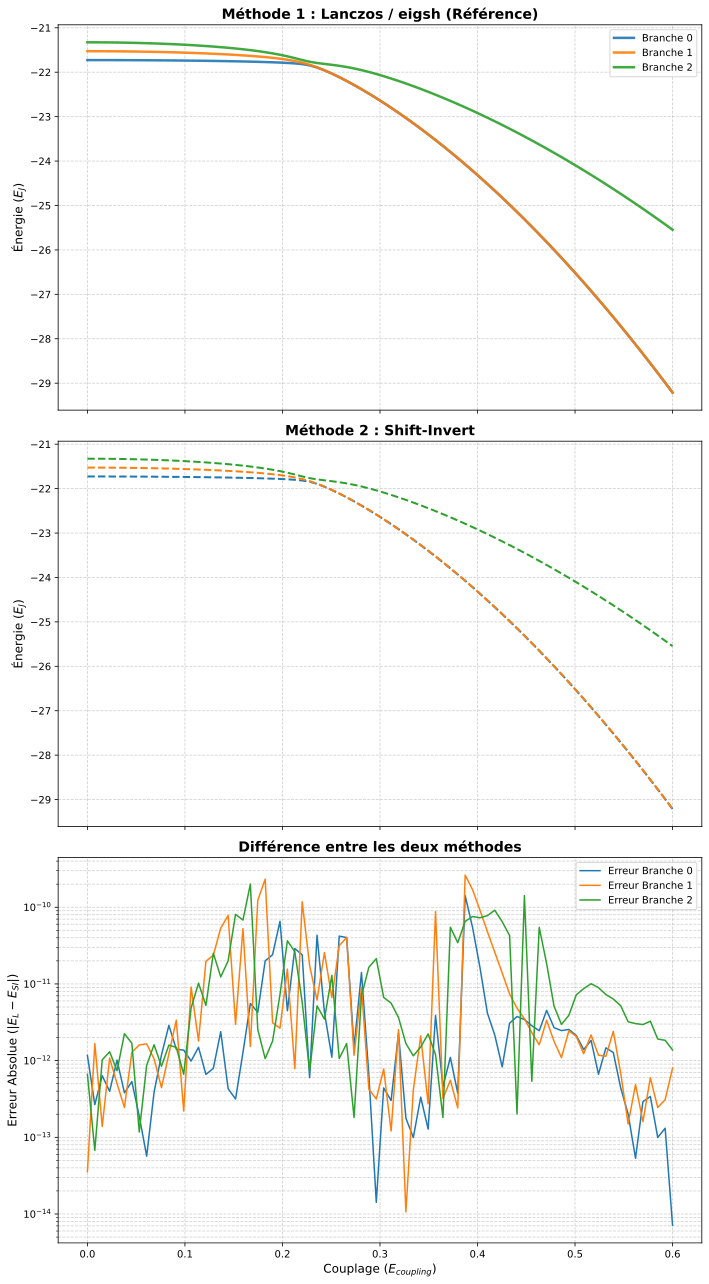

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Vérification des dimensions pour le plot
# Matplotlib aime avoir (n_steps, n_branches) pour tracer les colonnes.
# Si tes données sont (3, 80), on transpose pour avoir (80, 3).
if energies_l.shape[0] != len(coupling_list):
    energies_l = energies_l.T
if energies_si.shape[0] != len(coupling_list):
    energies_si = energies_si.T

# 2. Calcul de la différence (Erreur absolue)
diff = np.abs(energies_l - energies_si)

# 3. Création des 3 graphiques
fig, axs = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

# --- Plot 1 : Lanczos (Référence) ---
axs[0].plot(coupling_list, energies_l, linewidth=2.5, alpha=0.9)
axs[0].set_ylabel("Énergie ($E_J$)", fontsize=12)
axs[0].set_title("Méthode 1 : Lanczos / eigsh (Référence)", fontsize=14, fontweight="bold")
axs[0].grid(True, which="both", linestyle="--", alpha=0.6)
axs[0].legend([f"Branche {i}" for i in range(energies_l.shape[1])], loc="upper right")

# --- Plot 2 : Shift-Invert (Ton Algo) ---
# J'utilise des tirets (--) pour bien distinguer visuellement du trait plein
axs[1].plot(coupling_list, energies_si, linewidth=2, linestyle="--")
axs[1].set_ylabel("Énergie ($E_J$)", fontsize=12)
axs[1].set_title("Méthode 2 : Shift-Invert", fontsize=14, fontweight="bold")
axs[1].grid(True, which="both", linestyle="--", alpha=0.6)

# --- Plot 3 : Différence (Échelle Logarithmique) ---
# C'est ici qu'on juge la qualité de la convergence
for i in range(diff.shape[1]):
    axs[2].semilogy(coupling_list, diff[:, i], label=f"Erreur Branche {i}", linewidth=1.5)

axs[2].set_ylabel("Erreur Absolue ($|E_L - E_{SI}|$)", fontsize=12)
axs[2].set_xlabel("Couplage ($E_{coupling}$)", fontsize=12)
axs[2].set_title("Différence entre les deux méthodes", fontsize=14, fontweight="bold")
axs[2].grid(True, which="both", linestyle="--", alpha=0.6)
axs[2].legend()

# Mise en page
plt.tight_layout()
plt.show()